In [28]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import requests
import random

In [20]:
url =  "https://www.mit.edu/~ecprice/wordlist.10000"
words = response = requests.get(url).text.splitlines()
random.sample(words, 10)

['rather',
 'bend',
 'knights',
 'provincial',
 'bought',
 'click',
 'bestsellers',
 'tramadol',
 'beds',
 'jp']

In [3]:
len(words)

10000

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

In [6]:
X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([75880, 3]), torch.int64, torch.Size([75880]), torch.int64)

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [8]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

In [9]:

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([60647, 3]) torch.Size([60647])
torch.Size([7759, 3]) torch.Size([7759])
torch.Size([7474, 3]) torch.Size([7474])


In [10]:
C = torch.randn((27, 2))

In [11]:
emb = C[X]
emb.shape

torch.Size([75880, 3, 2])

In [12]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [13]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h, h.shape

(tensor([[-1.0000,  0.9413, -0.9922,  ..., -0.9992, -0.9094, -0.7754],
         [-1.0000,  0.9892, -0.8592,  ..., -1.0000,  0.4586, -0.9803],
         [-1.0000,  0.9413, -0.9922,  ..., -0.9992, -0.9094, -0.7754],
         ...,
         [-1.0000,  0.9999,  0.4914,  ..., -1.0000,  0.9843, -0.9937],
         [-0.9999, -0.5041, -0.9455,  ..., -1.0000,  0.8495, -0.3110],
         [-0.9998, -0.7412, -0.8924,  ..., -1.0000,  0.9990, -0.1154]]),
 torch.Size([75880, 100]))

In [14]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [15]:
logits = h @ W2 + b2
logits.shape

torch.Size([75880, 27])

In [16]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([75880, 27])

In [21]:
prob[torch.arange(32)].shape

torch.Size([32, 27])

In [17]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [75880]

In [22]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([60647, 3]), torch.Size([60647]))

In [23]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [24]:
for p in parameters:
  p.requires_grad = True

In [25]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [26]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

2.1161515712738037


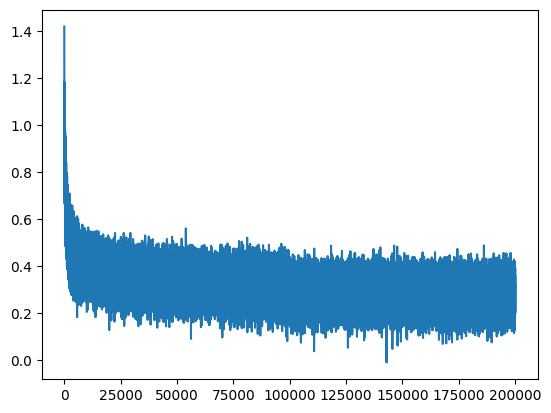

In [29]:
plt.plot(stepi, lossi)

In [30]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.9583, grad_fn=<NllLossBackward0>)

In [31]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1616, grad_fn=<NllLossBackward0>)

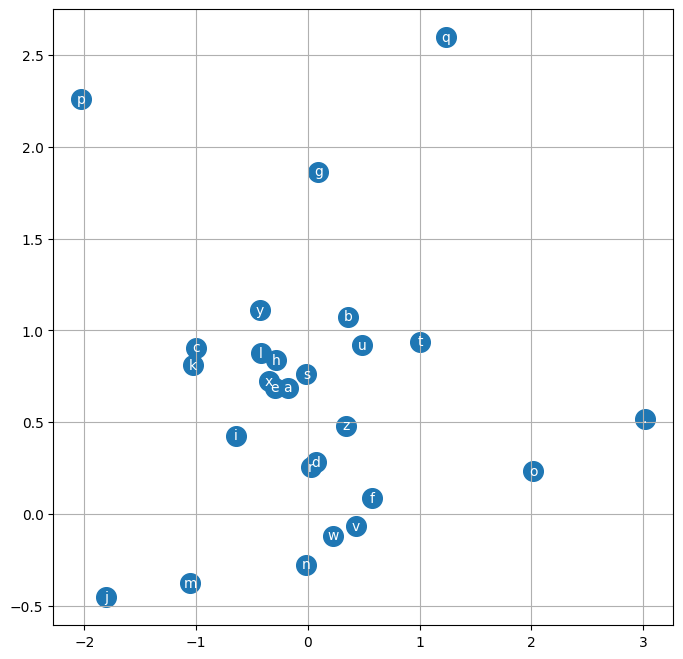

In [32]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [33]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [35]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size 
    while True:
      emb = C[torch.tensor([context])] 
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      if ix == 0:
        break
      out.append(ix)
    
    print(''.join(itos[i] for i in out))

eria
gmpants
evend
fill
returniend
log
adered
eliinstionent
deps
comparted
bios
traci
shob
rg
higher
contreall
pant
usature
ged
regitue
